<a href="https://colab.research.google.com/github/georgywasiat/KlasifyID/blob/main/KlasifyID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##KlasifyID
KlasifyID adalah aplikasi untuk mengklasifikasikan jawaban generatif AI versus jawaban manusia pada teks Bahasa Indonesia menggunakan metode TF-IDF dan Support Vector Machine.

Georgy Banny Rizky Wasiat

Priyo Sidik Sasongko, S.Si., M.Kom.

Edy Suharto, S.T., M.Kom.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
iot = pd.read_csv('/content/drive/My Drive/Skripsi/dataset_skripsi.csv')
iot.head(800)

,Text,Label,Sumber
0,Berikut adalah nama komponen utama arsitektur ...,J_MHS,Mahasiswa
1,1. CPU: untuk mengontrol operasi komputer dan ...,J_MHS,Mahasiswa
2,1. memori untuk menyimpan dalam sementara wakt...,J_MHS,Mahasiswa
3,Cpu : memproses data dan mengendalikan operasi...,J_MHS,Mahasiswa
4,"Control Unit Berfungsi sebagai ""otak"" kom...",J_MHS,Mahasiswa
...,...,...,...
795,Komputer terdiri dari tiga elemen utama yang s...,J_AI,Perplexity
796,Komputer terdiri dari beberapa komponen utama ...,J_AI,Perplexity
797,Komputer terdiri dari beberapa komponen utama ...,J_AI,Perplexity
798,Komputer terdiri dari beberapa komponen utama ...,J_AI,Perplexity


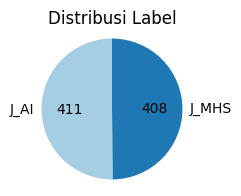

In [ ]:
# Hitung frekuensi setiap label
label_counts = iot['Label'].value_counts()

# Buat pie chart
plt.figure(figsize=(2,2))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: f'{int(p * sum(label_counts) / 100)}', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribusi Label')
plt.axis('equal')  # Membuat pie chart menjadi bulat
plt.show()

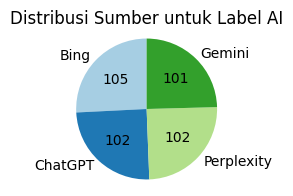

In [ ]:
import matplotlib.pyplot as plt

# Filter data di mana Label = "AI"
filtered_data = iot[iot['Label'] == 'J_AI']

# Hitung frekuensi setiap sumber
sumber_counts = filtered_data['Sumber'].value_counts()

# Buat pie chart jika ada data yang sesuai
if not sumber_counts.empty:
    plt.figure(figsize=(2,2))  # Ukuran diperbesar untuk tampilan yang lebih baik
    plt.pie(sumber_counts, labels=sumber_counts.index, autopct=lambda p: f'{int(p * sum(sumber_counts) / 100)}', startangle=90, colors=plt.cm.Paired.colors[:len(sumber_counts)])
    plt.title('Distribusi Sumber untuk Label AI')
    plt.axis('equal')  # Membuat pie chart menjadi bulat
    plt.show()
else:
    print("Tidak ada data dengan Label 'AI'")

##  Text Preprocessing

1. Cleaning

In [ ]:
def clean_text(text):
    # Membersihkan teks dari karakter \r\n\r\n dan \n\n
    text = text.replace('\r\n\r\n', ' ').replace('\n\n', ' ')

    # Menambahkan spasi sebelum dan setelah tanda baca
    for punctuation in string.punctuation:
        text = text.replace(punctuation, f' {punctuation} ')

    # Menghilangkan spasi berlebihan
    text = ' '.join(text.split())

    # Menghapus tanda baca dan simbol khusus
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Menghapus kata dengan panjang kurang dari 3 karakter
    text = ' '.join(word for word in text.split() if len(word) > 2)

    return text

# Membersihkan kolom 'Text' menggunakan fungsi clean_text
iot['Text_Cleaning'] = iot['Text'].apply(clean_text)

# Menghapus baris yang hanya berisi "-" atau kosong
iot = iot[(iot['Text_Cleaning'] != '-') & (iot['Text_Cleaning'].str.strip() != '')]

# Cetak dataset setelah pembersihan teks
print(iot[['Text_Cleaning', 'Label', 'Sumber']].head(40))


                                        Text_Cleaning  Label     Sumber
0   Berikut adalah nama komponen utama arsitektur ...  J_MHS  Mahasiswa
1   CPU untuk mengontrol operasi komputer dan menj...  J_MHS  Mahasiswa
2   memori untuk menyimpan dalam sementara waktu a...  J_MHS  Mahasiswa
3   Cpu memproses data dan mengendalikan operasi p...  J_MHS  Mahasiswa
4   Control Unit Berfungsi sebagai otak komputer m...  J_MHS  Mahasiswa
5   CPU Bertugas mengeksekusi instruksi dan mempro...  J_MHS  Mahasiswa
6   CPU Central Processing Unit Mengeksekusi instr...  J_MHS  Mahasiswa
7   cpu mengeksekusi intruksi main memory menyimpa...  J_MHS  Mahasiswa
8   UNIT PEMROSESAN SENTRAL CPU CENTRAL PROCESSING...  J_MHS  Mahasiswa
9   Memory adalah tempat penyimpanan data dan inst...  J_MHS  Mahasiswa
10  Unit Kontrol Bertugas mengatur dan mengendalik...  J_MHS  Mahasiswa
11  Unit Pemrosesan Sentral Central Processing Uni...  J_MHS  Mahasiswa
12  input output komputer menerima data atau instr...  J_MHS  Ma

2. Case Folding

In [ ]:
# Fungsi untuk case folding
def case_folding(text):
    # Mengubah huruf kapital menjadi huruf kecil
    return text.lower()

# Terapkan fungsi case folding ke kolom teks pada dataset
iot['Text_CaseFolding'] = iot['Text_Cleaning'].apply(case_folding)

# Cetak informasi dataset setelah case folding
print(iot[['Text_CaseFolding', 'Label', 'Sumber']].head(40))

                                     Text_CaseFolding  Label     Sumber
0   berikut adalah nama komponen utama arsitektur ...  J_MHS  Mahasiswa
1   cpu untuk mengontrol operasi komputer dan menj...  J_MHS  Mahasiswa
2   memori untuk menyimpan dalam sementara waktu a...  J_MHS  Mahasiswa
3   cpu memproses data dan mengendalikan operasi p...  J_MHS  Mahasiswa
4   control unit berfungsi sebagai otak komputer m...  J_MHS  Mahasiswa
5   cpu bertugas mengeksekusi instruksi dan mempro...  J_MHS  Mahasiswa
6   cpu central processing unit mengeksekusi instr...  J_MHS  Mahasiswa
7   cpu mengeksekusi intruksi main memory menyimpa...  J_MHS  Mahasiswa
8   unit pemrosesan sentral cpu central processing...  J_MHS  Mahasiswa
9   memory adalah tempat penyimpanan data dan inst...  J_MHS  Mahasiswa
10  unit kontrol bertugas mengatur dan mengendalik...  J_MHS  Mahasiswa
11  unit pemrosesan sentral central processing uni...  J_MHS  Mahasiswa
12  input output komputer menerima data atau instr...  J_MHS  Ma

<ipython-input-6-d98c3f015d40>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iot['Text_CaseFolding'] = iot['Text_Cleaning'].apply(case_folding)


3. Normalize

In [ ]:
# Membuat kamus typo dan normalisasi
normalisasi_kata = {
    "lma": "lama",
    "krluaran": "keluaran",
    "peyimpanan": "penyimpanan",
    "memeberikan": "memberikan",
    "utunk": "untuk",
    "untu": "untuk",
    "penghubunbg": "penghubung",
    "meprosesan": "memprosesan",
    "kompu": "komputer",
    "mengakitbatkan": "mengakibatkan",
    "hanyabisa": "hanya bisa",
    "memebrikan": "memberikan",
    "trsbt": "tersebut",
    "mejembatani": "menjembatani",
    "berfungsu": "berfungsi",
    "utk": "untuk",
    "untukk": "untuk",
    "intruksi": "instruksi",
    "dafa": "data",
    "penransferan": "pemindahan",
    "kompurer": "komputer",
    "mikrokontroll": "mikrokontrol",
    "prangkat": "perangkat",
    "masing2": "masing-masing",
    "outputin": "output in",
    "subuah": "sebuah",
    "memorytempat": "memory tempat",
    "memliki": "memiliki",
    "mengoprasikan": "mengoperasikan",
    "kedu": "kedua",
    "untunk": "untuk",
    "mengakitbatkan": "mengakibatkan",
    "digunakna": "digunakan",
    "menbg": "meng",
    "bissa": "bisa",
    "alumelakukan": "lalu melakukan",
    "komponen2": "komponen-komponen",
    "kontroller": "kontroler",
    "advan": "advance",
    "terdjri": "terdiri",
    "kegunaanya": "kegunaannya",
    "komputerter" : "komputer"
}

# Fungsi untuk normalisasi typo dan singkatan
def normalisasi_teks(text):
    for typo, correct in normalisasi_kata.items():
        text = text.replace(typo, correct)
    return text

# Terapkan normalisasi pada kolom teks
iot['Text_Normalized'] = iot['Text_CaseFolding'].apply(normalisasi_teks)

# Cetak hasil setelah normalisasi
print(iot[['Text_Normalized', 'Label', 'Sumber']].head(40))

                                      Text_Normalized  Label     Sumber
0   berikut adalah nama komponen utama arsitektur ...  J_MHS  Mahasiswa
1   cpu untuk mengontrol operasi komputer dan menj...  J_MHS  Mahasiswa
2   memori untuk menyimpan dalam sementara waktu a...  J_MHS  Mahasiswa
3   cpu memproses data dan mengendalikan operasi p...  J_MHS  Mahasiswa
4   control unit berfungsi sebagai otak komputer m...  J_MHS  Mahasiswa
5   cpu bertugas mengeksekusi instruksi dan mempro...  J_MHS  Mahasiswa
6   cpu central processing unit mengeksekusi instr...  J_MHS  Mahasiswa
7   cpu mengeksekusi instruksi main memory menyimp...  J_MHS  Mahasiswa
8   unit pemrosesan sentral cpu central processing...  J_MHS  Mahasiswa
9   memory adalah tempat penyimpanan data dan inst...  J_MHS  Mahasiswa
10  unit kontrol bertugas mengatur dan mengendalik...  J_MHS  Mahasiswa
11  unit pemrosesan sentral central processing uni...  J_MHS  Mahasiswa
12  input output komputer menerima data atau instr...  J_MHS  Ma

<ipython-input-7-0e7930e7998e>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iot['Text_Normalized'] = iot['Text_CaseFolding'].apply(normalisasi_teks)


4. Tokenization

In [ ]:
# Fungsi untuk melakukan tokenisasi
def tokenisasi(text):
    # Menggunakan word_tokenize dari NLTK untuk memecah teks menjadi kata-kata
    return nltk.word_tokenize(text)

# Terapkan fungsi tokenisasi ke kolom 'Text' pada dataset
iot['Text_Token'] = iot['Text_Normalized'].apply(tokenisasi)

# Cetak dataset setelah proses tokenisasi
print(iot[['Text_Token', 'Label', 'Sumber']].head(40))


                                           Text_Token  Label     Sumber
0   [berikut, adalah, nama, komponen, utama, arsit...  J_MHS  Mahasiswa
1   [cpu, untuk, mengontrol, operasi, komputer, da...  J_MHS  Mahasiswa
2   [memori, untuk, menyimpan, dalam, sementara, w...  J_MHS  Mahasiswa
3   [cpu, memproses, data, dan, mengendalikan, ope...  J_MHS  Mahasiswa
4   [control, unit, berfungsi, sebagai, otak, komp...  J_MHS  Mahasiswa
5   [cpu, bertugas, mengeksekusi, instruksi, dan, ...  J_MHS  Mahasiswa
6   [cpu, central, processing, unit, mengeksekusi,...  J_MHS  Mahasiswa
7   [cpu, mengeksekusi, instruksi, main, memory, m...  J_MHS  Mahasiswa
8   [unit, pemrosesan, sentral, cpu, central, proc...  J_MHS  Mahasiswa
9   [memory, adalah, tempat, penyimpanan, data, da...  J_MHS  Mahasiswa
10  [unit, kontrol, bertugas, mengatur, dan, menge...  J_MHS  Mahasiswa
11  [unit, pemrosesan, sentral, central, processin...  J_MHS  Mahasiswa
12  [input, output, komputer, menerima, data, atau...  J_MHS  Ma

5. Filtering (Stopwords Removal)

In [ ]:
# Fungsi untuk menghapus stopword dari teks yang sudah dalam bentuk token
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('indonesian'))  # Menggunakan stopwords bahasa Indonesia
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

# Terapkan fungsi untuk menghapus stopwords pada kolom tokenisasi di dataset
iot['Text_Stopwords'] = iot['Text_Token'].apply(remove_stopwords)

# Cetak informasi dataset setelah penghapusan stopwords
print(iot[['Text_Stopwords', 'Label', 'Sumber']].head(25))

                                       Text_Stopwords  Label     Sumber
0   [nama, komponen, utama, arsitektur, komputer, ...  J_MHS  Mahasiswa
1   [cpu, mengontrol, operasi, komputer, menjalank...  J_MHS  Mahasiswa
2                                 [memori, menyimpan]  J_MHS  Mahasiswa
3   [cpu, memproses, data, mengendalikan, operasi,...  J_MHS  Mahasiswa
4   [control, unit, berfungsi, otak, komputer, men...  J_MHS  Mahasiswa
5   [cpu, bertugas, mengeksekusi, instruksi, mempr...  J_MHS  Mahasiswa
6   [cpu, central, processing, unit, mengeksekusi,...  J_MHS  Mahasiswa
7   [cpu, mengeksekusi, instruksi, main, memory, m...  J_MHS  Mahasiswa
8   [unit, pemrosesan, sentral, cpu, central, proc...  J_MHS  Mahasiswa
9   [memory, penyimpanan, data, instruksi, diprose...  J_MHS  Mahasiswa
10  [unit, kontrol, bertugas, mengatur, mengendali...  J_MHS  Mahasiswa
11  [unit, pemrosesan, sentral, central, processin...  J_MHS  Mahasiswa
12  [input, output, komputer, menerima, data, inst...  J_MHS  Ma

6. Stemming

In [ ]:
# Membuat objek stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk melakukan stemming
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

# Terapkan fungsi stemming ke kolom Tokens pada DataFrame
iot.loc[:, 'Stemmed_Tokens'] = iot.loc[:, 'Text_Stopwords'].apply(stem_tokens)

# Cetak informasi dataset setelah tokenisasi dan stemming
print(iot[['Stemmed_Tokens', 'Label', 'Sumber']].head(20))

                                       Stemmed_Tokens  Label     Sumber
0   [nama, komponen, utama, arsitektur, komputer, ...  J_MHS  Mahasiswa
1   [cpu, kontrol, operasi, komputer, jalan, fungs...  J_MHS  Mahasiswa
2                                    [memori, simpan]  J_MHS  Mahasiswa
3   [cpu, proses, data, kendali, operasi, komputer...  J_MHS  Mahasiswa
4   [control, unit, fungsi, otak, komputer, atur, ...  J_MHS  Mahasiswa
5   [cpu, tugas, eksekusi, instruksi, proses, data...  J_MHS  Mahasiswa
6   [cpu, central, processing, unit, eksekusi, ins...  J_MHS  Mahasiswa
7   [cpu, eksekusi, instruksi, main, memory, simpa...  J_MHS  Mahasiswa
8   [unit, pemrosesan, sentral, cpu, central, proc...  J_MHS  Mahasiswa
9   [memory, simpan, data, instruksi, proses, cpu,...  J_MHS  Mahasiswa
10  [unit, kontrol, tugas, atur, kendali, operasi,...  J_MHS  Mahasiswa
11  [unit, pemrosesan, sentral, central, processin...  J_MHS  Mahasiswa
12  [input, output, komputer, terima, data, instru...  J_MHS  Ma

## Data Spliting

In [ ]:
#Membagi dataset menjadi 90% untuk pelatihan dan 10% untuk test
iot_train, iot_test = train_test_split(iot[['Stemmed_Tokens', 'Label', 'Sumber']], test_size=0.10, random_state=42)

In [ ]:
# Memisahkan fitur dan label untuk data pelatihan dan pengujian
X_train = iot_train['Stemmed_Tokens']
y_train = iot_train['Label']
X_test = iot_test['Stemmed_Tokens']
y_test = iot_test['Label']

## Feature Extraction

In [ ]:
# Menggabungkan token menjadi string (jika token dalam bentuk list)
X_train = X_train.apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)
X_test = X_test.apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)

# Menggunakan CountVectorizer untuk menghitung frekuensi kata
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Menggunakan TfidfTransformer untuk mengubah frekuensi kata menjadi representasi TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Menampilkan ukuran representasi TF-IDF
print(f'Ukuran set pelatihan TF-IDF: {X_train_tfidf.shape}')
print(f'Ukuran set pengujian TF-IDF: {X_test_tfidf.shape}')

Ukuran set pelatihan TF-IDF: (720, 1378)
Ukuran set pengujian TF-IDF: (80, 1378)


## Modeling and Evaluation

1. SVM dengan Kernel Linear

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Daftar nilai C yang ingin dicoba
C_values = [0.1, 1, 10, 100]
accuracies = {}

# Melakukan klasifikasi dengan setiap nilai C
for C in C_values:
    model = SVC(kernel='linear', C=C)

    # Melakukan cross-validation (misalnya, 10-fold cross-validation)
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=10, scoring='accuracy')  # Menggunakan 10-fold cross-validation

    # Menyimpan rata-rata akurasi dari cross-validation
    accuracies[C] = scores.mean()

# Menampilkan akurasi untuk setiap nilai C
print("\nAkurasi rata-rata untuk masing-masing nilai C (cross-validation):")
for C, acc in accuracies.items():
    print(f'C = {C}: Akurasi = {acc:.4f}')



Akurasi rata-rata untuk masing-masing nilai C (cross-validation):
C = 0.1: Akurasi = 0.8778
C = 1: Akurasi = 0.9153
C = 10: Akurasi = 0.9097
C = 100: Akurasi = 0.9000


2. SVM dengan Kernel RBF

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Daftar nilai C dan gamma yang ingin dicoba
C_values = [0.1, 1, 10, 100]
gamma_values = [0.1, 1, 10]
results = {}

# Melakukan klasifikasi dengan setiap kombinasi C dan gamma
for C in C_values:
    for gamma in gamma_values:
        model = SVC(kernel='rbf', C=C, gamma=gamma)

        # Melakukan cross-validation (misalnya, 10-fold cross-validation)
        scores = cross_val_score(model, X_train_tfidf, y_train, cv=10, scoring='accuracy')  # Menggunakan 10-fold cross-validation

        # Menyimpan rata-rata akurasi dari cross-validation
        results[(C, gamma)] = scores.mean()

# Menampilkan akurasi rata-rata untuk setiap kombinasi C dan gamma
print("\nAkurasi rata-rata untuk masing-masing kombinasi C dan gamma (cross-validation):")
for (C, gamma), acc in results.items():
    print(f'C = {C}, gamma = {gamma}: Akurasi = {acc:.4f}')



Akurasi rata-rata untuk masing-masing kombinasi C dan gamma (cross-validation):
C = 0.1, gamma = 0.1: Akurasi = 0.5181
C = 0.1, gamma = 1: Akurasi = 0.8625
C = 0.1, gamma = 10: Akurasi = 0.5139
C = 1, gamma = 0.1: Akurasi = 0.8889
C = 1, gamma = 1: Akurasi = 0.9250
C = 1, gamma = 10: Akurasi = 0.7042
C = 10, gamma = 0.1: Akurasi = 0.9236
C = 10, gamma = 1: Akurasi = 0.9347
C = 10, gamma = 10: Akurasi = 0.7375
C = 100, gamma = 0.1: Akurasi = 0.9153
C = 100, gamma = 1: Akurasi = 0.9347
C = 100, gamma = 10: Akurasi = 0.7375


3. SVM dengan Kernel Polynomial

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Daftar nilai C, gamma, dan degree yang ingin dicoba
C_values = [0.1, 1, 10, 100]
gamma_values = [0.1, 1, 10]
degree_values = [2, 3, 4]
results = {}

# Melakukan klasifikasi dengan setiap kombinasi C, gamma, dan degree
for C in C_values:
    for gamma in gamma_values:
        for degree in degree_values:
            model = SVC(kernel='poly', C=C, gamma=gamma, degree=degree)

            # Melakukan cross-validation (misalnya, 10-fold cross-validation)
            scores = cross_val_score(model, X_train_tfidf, y_train, cv=10, scoring='accuracy')  # 10-fold cross-validation

            # Menyimpan rata-rata akurasi dari cross-validation
            results[(C, gamma, degree)] = scores.mean()

# Menampilkan akurasi rata-rata untuk setiap kombinasi C, gamma, dan degree
print("\nAkurasi rata-rata untuk masing-masing kombinasi C, gamma, dan degree (cross-validation):")
for (C, gamma, degree), acc in results.items():
    print(f'C = {C}, gamma = {gamma}, degree = {degree}: Akurasi = {acc:.4f}')



Akurasi rata-rata untuk masing-masing kombinasi C, gamma, dan degree (cross-validation):
C = 0.1, gamma = 0.1, degree = 2: Akurasi = 0.5139
C = 0.1, gamma = 0.1, degree = 3: Akurasi = 0.5139
C = 0.1, gamma = 0.1, degree = 4: Akurasi = 0.5139
C = 0.1, gamma = 1, degree = 2: Akurasi = 0.8597
C = 0.1, gamma = 1, degree = 3: Akurasi = 0.8042
C = 0.1, gamma = 1, degree = 4: Akurasi = 0.8083
C = 0.1, gamma = 10, degree = 2: Akurasi = 0.9361
C = 0.1, gamma = 10, degree = 3: Akurasi = 0.9167
C = 0.1, gamma = 10, degree = 4: Akurasi = 0.8944
C = 1, gamma = 0.1, degree = 2: Akurasi = 0.5139
C = 1, gamma = 0.1, degree = 3: Akurasi = 0.5139
C = 1, gamma = 0.1, degree = 4: Akurasi = 0.5139
C = 1, gamma = 1, degree = 2: Akurasi = 0.9306
C = 1, gamma = 1, degree = 3: Akurasi = 0.9097
C = 1, gamma = 1, degree = 4: Akurasi = 0.8847
C = 1, gamma = 10, degree = 2: Akurasi = 0.9361
C = 1, gamma = 10, degree = 3: Akurasi = 0.9167
C = 1, gamma = 10, degree = 4: Akurasi = 0.8944
C = 10, gamma = 0.1, degree 

## Mencari Parameter Terbaik dari K-Fold

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Menentukan parameter grid untuk masing-masing kernel
param_grid = {
    'linear': {
        'C': [0.1, 1, 10, 100]
    },
    'poly': {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.1, 1, 10],
        'degree': [2, 3, 4]
    },
    'rbf': {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.1, 1, 10]
    }
}

# Menyimpan hasil terbaik untuk masing-masing kernel
best_models = {}

# Melakukan Grid Search untuk setiap kernel
for kernel, params in param_grid.items():
    print(f"Melakukan Grid Search untuk kernel: {kernel}")

    # Menentukan parameter yang sesuai dengan kernel yang dipilih
    if kernel == 'linear':
        model = SVC(kernel='linear')
    elif kernel == 'poly':
        model = SVC(kernel='poly')
    else:
        model = SVC(kernel='rbf')

    # Membuat GridSearchCV
    grid = GridSearchCV(model, param_grid=params, cv=10, scoring='accuracy')

    # Melatih model dan mencari parameter terbaik
    grid.fit(X_train_tfidf, y_train)

    # Menyimpan hasil terbaik
    best_models[kernel] = (grid.best_params_, grid.best_score_)
    print(f'Best parameters for {kernel}: {grid.best_params_}')
    print(f'Best accuracy for {kernel}: {grid.best_score_:.4f}\n')

# Menampilkan model terbaik untuk setiap kernel
print("\nModel terbaik untuk setiap kernel:")
for kernel, (params, accuracy) in best_models.items():
    print(f'{kernel}: {params}, Akurasi: {accuracy:.4f}')


Melakukan Grid Search untuk kernel: linear
Best parameters for linear: {'C': 1}
Best accuracy for linear: 0.9153

Melakukan Grid Search untuk kernel: poly
Best parameters for poly: {'C': 0.1, 'degree': 2, 'gamma': 10}
Best accuracy for poly: 0.9361

Melakukan Grid Search untuk kernel: rbf
Best parameters for rbf: {'C': 10, 'gamma': 1}
Best accuracy for rbf: 0.9347


Model terbaik untuk setiap kernel:
linear: {'C': 1}, Akurasi: 0.9153
poly: {'C': 0.1, 'degree': 2, 'gamma': 10}, Akurasi: 0.9361
rbf: {'C': 10, 'gamma': 1}, Akurasi: 0.9347


## Menerapkan ke Data Testing

1. Kernel Linear

In [ ]:
# Membuat model SVM dengan kernel linear dan C = 100
model = SVC(kernel='linear', C=1)

# Melatih model dengan data pelatihan
model.fit(X_train_tfidf, y_train)

# Melakukan prediksi pada set pengujian (X_test)
y_pred_test = model.predict(X_test_tfidf)

# Menghitung akurasi pada set pengujian
test_accuracy = accuracy_score(y_test, y_pred_test)

# Menampilkan hasil akurasi
print(f'Akurasi pada set pengujian dengan C = 1: {test_accuracy}')


Akurasi pada set pengujian dengan C = 1: 0.9125


2. Kernel RBF

In [ ]:
# Membuat model SVM dengan kernel RBF, C = 1, dan gamma = 1
model = SVC(kernel='rbf', C=10, gamma=1)

# Melatih model dengan data pelatihan
model.fit(X_train_tfidf, y_train)

# Melakukan prediksi pada set pengujian (X_test)
y_pred_test = model.predict(X_test_tfidf)

# Menghitung akurasi pada set pengujian
test_accuracy = accuracy_score(y_test, y_pred_test)

# Menampilkan hasil akurasi
print(f'Akurasi pada set pengujian dengan C = 10 dan gamma = 1: {test_accuracy}')


Akurasi pada set pengujian dengan C = 10 dan gamma = 1: 0.8875


3. Kernel Polynomial

In [ ]:
# Membuat model SVM dengan kernel polinomial, C = 0.1, gamma = 10, dan degree = 2
model = SVC(kernel='poly', C=0.1, gamma=10, degree=2)

# Melatih model dengan data pelatihan
model.fit(X_train_tfidf, y_train)

# Melakukan prediksi pada set pengujian (X_test)
y_pred_test = model.predict(X_test_tfidf)

# Menghitung akurasi pada set pengujian
test_accuracy = accuracy_score(y_test, y_pred_test)

# Menampilkan hasil akurasi
print(f'Akurasi pada set pengujian dengan C = 0.1, gamma = 10, dan degree = 2: {test_accuracy}')


Akurasi pada set pengujian dengan C = 0.1, gamma = 10, dan degree = 2: 0.8875


Confusion Matrix

Membuat confusion matrix dan menghitung metrik evaluasi untuk kernel: linear


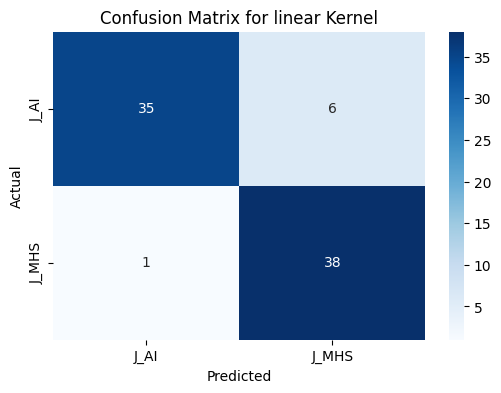

Precision for linear: 0.9192866161616161
Recall for linear: 0.9125
F1-Score for linear: 0.9122946330777655

Membuat confusion matrix dan menghitung metrik evaluasi untuk kernel: poly


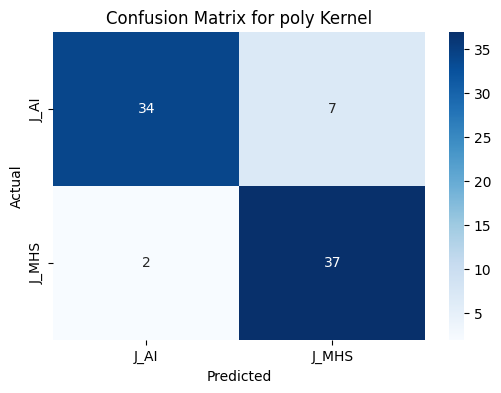

Precision for poly: 0.8939709595959595
Recall for poly: 0.8875
F1-Score for poly: 0.8872359568142703

Membuat confusion matrix dan menghitung metrik evaluasi untuk kernel: rbf


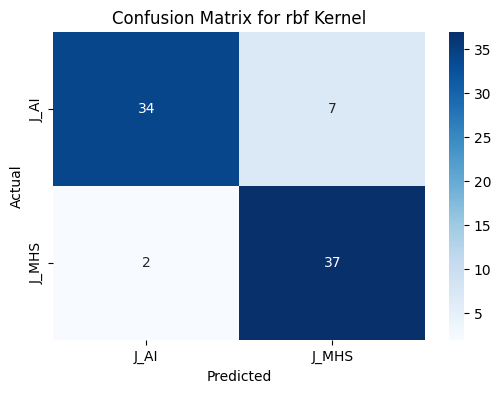

Precision for rbf: 0.8939709595959595
Recall for rbf: 0.8875
F1-Score for rbf: 0.8872359568142703



In [ ]:
# Parameter terbaik yang sudah diketahui
best_params = {
    'linear': {'C': 1},
    'poly': {'C': 0.1, 'gamma': 10, 'degree': 2},
    'rbf': {'C': 10, 'gamma': 1}
}

# Membuat confusion matrix dan menghitung metrik evaluasi untuk setiap kernel
for kernel, params in best_params.items():
    print(f"Membuat confusion matrix dan menghitung metrik evaluasi untuk kernel: {kernel}")

    # Menginisialisasi model terbaik berdasarkan parameter yang telah diperoleh
    if kernel == 'linear':
        model = SVC(kernel=kernel, C=params['C'])
    elif kernel == 'poly':
        model = SVC(kernel=kernel, C=params['C'], gamma=params['gamma'], degree=params['degree'])
    else:  # kernel == 'rbf'
        model = SVC(kernel=kernel, C=params['C'], gamma=params['gamma'])

    # Melatih model dengan data training
    model.fit(X_train_tfidf, y_train)

    # Melakukan prediksi terhadap data uji
    y_pred = model.predict(X_test_tfidf)

    # Menghitung confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Menghitung precision, recall, dan f1-score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Menampilkan confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {kernel} Kernel')
    plt.show()

    # Menampilkan metrik evaluasi
    print(f"Precision for {kernel}: {precision}")
    print(f"Recall for {kernel}: {recall}")
    print(f"F1-Score for {kernel}: {f1}\n")


Data yang salah klasifikasi pada Kernel Linear

In [ ]:
# Model Linear
model_linear = SVC(kernel='linear', C=best_params['linear']['C'])
model_linear.fit(X_train_tfidf, y_train)
y_pred_linear = model_linear.predict(X_test_tfidf)

# Menemukan data yang salah klasifikasi untuk kernel Linear
misclassified_indices_linear = [i for i in range(len(y_test)) if y_test.iloc[i] != y_pred_linear[i]]

print(f"\nData yang salah klasifikasi untuk kernel Linear:")
for idx in misclassified_indices_linear:
    print(f"Index: {idx}, Actual: {y_test.iloc[idx]}, Predicted: {y_pred_linear[idx]}")



Data yang salah klasifikasi untuk kernel Linear:
Index: 3, Actual: J_AI, Predicted: J_MHS
Index: 16, Actual: J_MHS, Predicted: J_AI
Index: 19, Actual: J_AI, Predicted: J_MHS
Index: 45, Actual: J_AI, Predicted: J_MHS
Index: 49, Actual: J_AI, Predicted: J_MHS
Index: 60, Actual: J_AI, Predicted: J_MHS
Index: 77, Actual: J_AI, Predicted: J_MHS


Data yang salah klasifikasi pada Kernel RBF

In [ ]:
# Model RBF
model_rbf = SVC(kernel='rbf', C=best_params['rbf']['C'], gamma=best_params['rbf']['gamma'])
model_rbf.fit(X_train_tfidf, y_train)
y_pred_rbf = model_rbf.predict(X_test_tfidf)

# Menemukan data yang salah klasifikasi untuk kernel RBF
misclassified_indices_rbf = [i for i in range(len(y_test)) if y_test.iloc[i] != y_pred_rbf[i]]

print(f"\nData yang salah klasifikasi untuk kernel RBF:")
for idx in misclassified_indices_rbf:
    print(f"Index: {idx}, Actual: {y_test.iloc[idx]}, Predicted: {y_pred_rbf[idx]}")



Data yang salah klasifikasi untuk kernel RBF:
Index: 3, Actual: J_AI, Predicted: J_MHS
Index: 10, Actual: J_MHS, Predicted: J_AI
Index: 16, Actual: J_MHS, Predicted: J_AI
Index: 19, Actual: J_AI, Predicted: J_MHS
Index: 45, Actual: J_AI, Predicted: J_MHS
Index: 49, Actual: J_AI, Predicted: J_MHS
Index: 60, Actual: J_AI, Predicted: J_MHS
Index: 61, Actual: J_AI, Predicted: J_MHS
Index: 77, Actual: J_AI, Predicted: J_MHS


Data yang salah klasifikasi pada Kernel Polynomial

In [ ]:
# Model Polynomial
model_poly = SVC(kernel='poly', C=best_params['poly']['C'], gamma=best_params['poly']['gamma'], degree=best_params['poly']['degree'])
model_poly.fit(X_train_tfidf, y_train)
y_pred_poly = model_poly.predict(X_test_tfidf)

# Menemukan data yang salah klasifikasi untuk kernel Polynomial
misclassified_indices_poly = [i for i in range(len(y_test)) if y_test.iloc[i] != y_pred_poly[i]]

print(f"\nData yang salah klasifikasi untuk kernel Polynomial:")
for idx in misclassified_indices_poly:
    print(f"Index: {idx}, Actual: {y_test.iloc[idx]}, Predicted: {y_pred_poly[idx]}")



Data yang salah klasifikasi untuk kernel Polynomial:
Index: 3, Actual: J_AI, Predicted: J_MHS
Index: 10, Actual: J_MHS, Predicted: J_AI
Index: 16, Actual: J_MHS, Predicted: J_AI
Index: 19, Actual: J_AI, Predicted: J_MHS
Index: 45, Actual: J_AI, Predicted: J_MHS
Index: 49, Actual: J_AI, Predicted: J_MHS
Index: 60, Actual: J_AI, Predicted: J_MHS
Index: 61, Actual: J_AI, Predicted: J_MHS
Index: 77, Actual: J_AI, Predicted: J_MHS
